# Feature Importance in Price
1. Calculating price velocity and acceleration of NFTs
2. Price Forecasting NFTs

### 0. Set Up

In [3]:
import sqlite3
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime as dt
import networkx as nx 

In [4]:
db_path = '/Users/chris/Desktop/Data Science/NFT/nfts.sqlite'
conn = sqlite3.connect(db_path)
c = conn.cursor()

### 1. Project Value Velocity and Acceleration

### Findings
- Fit linear regressions to to price and timestamp each of the NFTs (that had 3 or more transactions)
    - Plotted the top 10 linear regression slopes
    - Slopes looked VERY steep over a very short period of time
- Artificial Inflation
    - For 9 out of the 10 NFTs, the data points were all within one day of each other
        - The other point had a difference of 3 days
    - 7 out of the 10 had sold the NFT back to a previous owner at some point 
    - Possible that people are inflating the prices by selling the NFT to another wallet they own, thereby fabricating a transaction history
- Additional Findings:
    - Token 6 is odd because it is disjoint, possibly because I filtered out transactions with value 0 

### Notes
- Did not carry out acceleration calculations or price forecasting because there seemed to be an artifical increase in price


In [5]:
# Gathering data from sqlite db
sql_1 = """
select nft_address, token_id, transaction_value, timestamp
from transfers
where transaction_value != 0
order by timestamp;
"""

c.execute(sql_1)
data_1 = c.fetchall()

In [6]:
value = []
timestamp = []
for trans in data_1:
    value.append(trans[2])
    timestamp.append(trans[3])

Text(0, 0.5, 'Amount WEI')

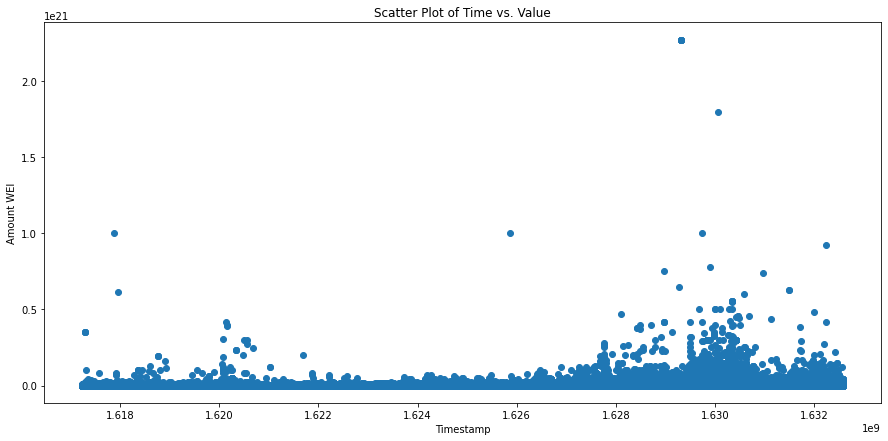

In [58]:
plt.figure(figsize=(15,7))
plt.scatter(np.array(timestamp), np.array(value))
plt.title('Scatter Plot of Time vs. Value')
plt.xlabel('Timestamp')
plt.ylabel('Amount WEI') # 1 ether = 10e18 WEI 

In [8]:
# Matching  transactions to the token that was traded
tokens = []
for i in data_1:
    tokens.append(i[1])

unique_tokens = np.unique(tokens)
token_dict = dict()
for token_id in unique_tokens:
    token_dict[token_id] = []
for record in data_1:
    token_dict[record[1]].append((record[2], record[3]))

In [9]:
# Eliminating tokens with 2 or less transactions
to_pop = []
for i in token_dict:
    if len(token_dict[i]) < 3:
        to_pop.append(i)

for i in to_pop:
    token_dict.pop(i)

In [10]:
# Calculating linear regressions for remaining NFTs
lin_reg_slopes = dict()
for i in token_dict:
    lin_reg_slopes[i] = []
for token in token_dict:
    x = []
    y = []
    for record in token_dict[token]:
        x.append(record[1])
        y.append(record[0])
    m,b = np.polyfit(x,y,1)
    
    lin_reg_slopes[token] = b

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
top_10 = sorted(lin_reg_slopes, key=lin_reg_slopes.get, reverse=True)[:10]

In [12]:
for i in top_10:
    print(lin_reg_slopes[i])

1.5473694726815194e+25
5.624350831716735e+24
6.595667904988324e+23
5.386370204058075e+23
3.249792295866881e+23
3.240134535354974e+23
2.5373028198874994e+23
2.0609424578709595e+23
2.060200175404587e+23
1.8422884542939792e+23


In [13]:
top_10_dict = dict()
for i in top_10:
    top_10_dict[i] = []
    
for i in token_dict:
    if i in top_10_dict:
        top_10_dict[i] = token_dict[i]

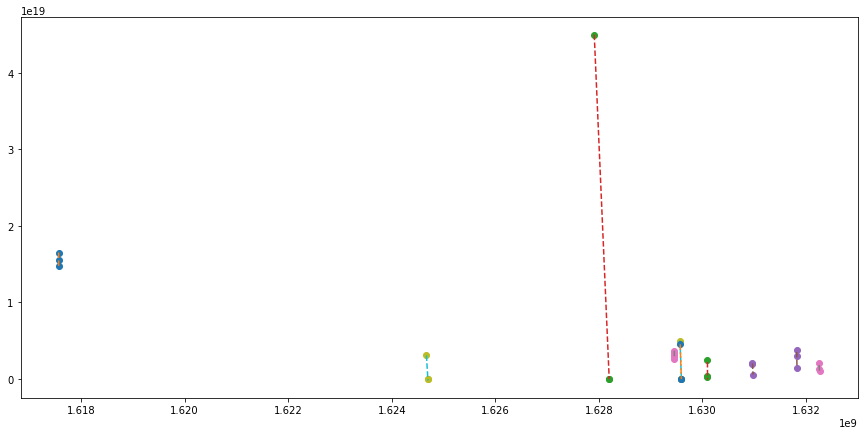

In [14]:
plt.figure(figsize=(15,7))
for token in top_10_dict:
    x = []
    y = []
    for record in top_10_dict[token]:
        x.append(record[1])
        y.append(record[0])
    coef = np.polyfit(x,y,1)
    poly1d_fn = np.poly1d(coef)
    
    plt.plot(x,y, 'o', x, poly1d_fn(x), '--')


In [15]:
new_dict = dict()
for i in top_10_dict:
    new_dict[i] = []
    
for i in top_10_dict:
    for record in top_10_dict[i]:
        new_dict[i].append(dt.fromtimestamp(record[1]))

In [16]:
differences = []
for i in new_dict:
    diff = new_dict[i][-1]-new_dict[i][0] 
    differences.append(diff)

In [17]:
differences

[datetime.timedelta(seconds=182),
 datetime.timedelta(seconds=662),
 datetime.timedelta(seconds=4712),
 datetime.timedelta(seconds=3152),
 datetime.timedelta(seconds=25328),
 datetime.timedelta(seconds=22887),
 datetime.timedelta(days=3, seconds=29936),
 datetime.timedelta(seconds=11535),
 datetime.timedelta(seconds=6872),
 datetime.timedelta(seconds=28969)]

### 1b. Determining if the top 10 are self inflated

In [18]:
sql_1b = """
select token_id, from_address, to_address
from transfers
where 
    token_id = '731640' or
    token_id = '16770' or 
    token_id = '162000456' or
    token_id = '1208824' or 
    token_id = '137000286' or 
    token_id = '137000934' or 
    token_id = '7000100' or 
    token_id = '333355' or
    token_id = '164000949' or
    token_id = '23000433'
order by token_id, timestamp
"""

c.execute(sql_1b)
data_1b = c.fetchall()

In [19]:
df_1b = pd.DataFrame(data_1b)
df_1b.columns = ['token_id', 'sender', 'receiver']
df_1b.head()

,token_id,sender,receiver
0,1208824,0xCda8073d91Beda5766E6354cF050E5d587215960,0xe67CcEc6e2994685a911abE12fEFdB50a5Ef9F97
1,1208824,0xe67CcEc6e2994685a911abE12fEFdB50a5Ef9F97,0xB1bA4CfA6b12d7A315A5137170AAccfd0764B6f4
2,1208824,0xB1bA4CfA6b12d7A315A5137170AAccfd0764B6f4,0x5A2996C9B6E9F08BACa5826F24182d21BC9533eD
3,1208824,0x5A2996C9B6E9F08BACa5826F24182d21BC9533eD,0x0dDFc16197A0D7f7dbcf80BFF542A3Dd7b7a9712
4,1208824,0x0dDFc16197A0D7f7dbcf80BFF542A3Dd7b7a9712,0x57628567a728F9370124Afb8601f7B72417e1690


In [20]:
ids = list(df_1b['sender']) + list(df_1b['receiver'])
unique_ids = np.unique(ids)

In [21]:
enum_dict = dict()
for idx, i in enumerate(unique_ids):
    enum_dict[i] = idx

In [22]:
df_1c = df_1b.replace({'sender': enum_dict})
df_1c = df_1c.replace({'receiver': enum_dict})

In [23]:
token_1 = df_1c[df_1c['token_id'] == '1208824']
token_2 = df_1c[df_1c['token_id'] == '137000286']
token_3 = df_1c[df_1c['token_id'] == '137000934']
token_4 = df_1c[df_1c['token_id'] == '162000456']
token_5 = df_1c[df_1c['token_id'] == '164000949']
token_6 = df_1c[df_1c['token_id'] == '16770']
token_7 = df_1c[df_1c['token_id'] == '23000433']
token_8 = df_1c[df_1c['token_id'] == '333355']
token_9 = df_1c[df_1c['token_id'] == '7000100']
token_10 = df_1c[df_1c['token_id'] == '731640']

In [24]:
token_1

,token_id,sender,receiver
0,1208824,38,51
1,1208824,51,36
2,1208824,36,20
3,1208824,20,7
4,1208824,7,19
5,1208824,19,38


In [25]:
def create_nodes(df):
    nodes = []
    for i in range(len(df)):
        app = (df.iloc[i]['sender'], df.iloc[i]['receiver'])
        nodes.append(app)

    return nodes

In [26]:
def create_graph(nodes, idx):
    G = nx.DiGraph()
    G.add_edges_from(nodes)
    plt.figure(figsize=(15,8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='purple')
    nx.draw_networkx_edges(G, pos, edgelist=G.edges, arrowsize=40, edge_color='black')
    nx.draw_networkx_labels(G, pos, font_color="whitesmoke")
    plt.title('Timespan: {}'.format(differences[idx]))
    plt.show()

In [27]:
token_1

,token_id,sender,receiver
0,1208824,38,51
1,1208824,51,36
2,1208824,36,20
3,1208824,20,7
4,1208824,7,19
5,1208824,19,38


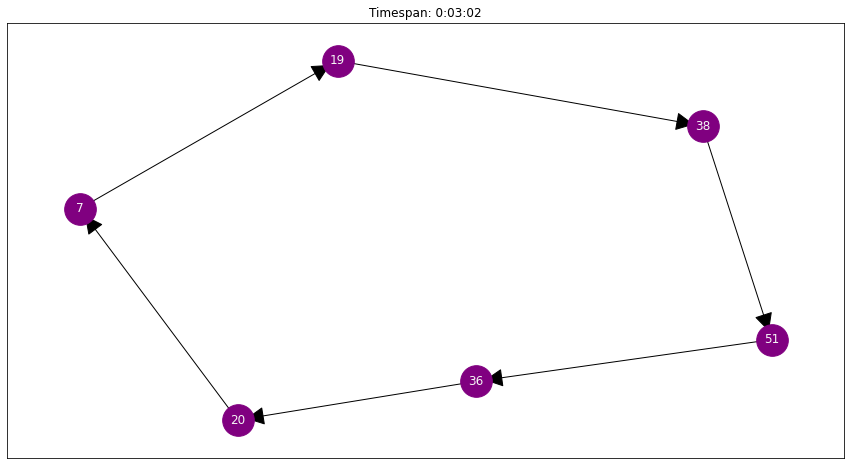

In [28]:
create_graph(create_nodes(token_1), 0)

In [29]:
token_2

,token_id,sender,receiver
6,137000286,21,45
7,137000286,45,30
8,137000286,30,10
9,137000286,10,30
10,137000286,30,10
11,137000286,10,4
12,137000286,4,11


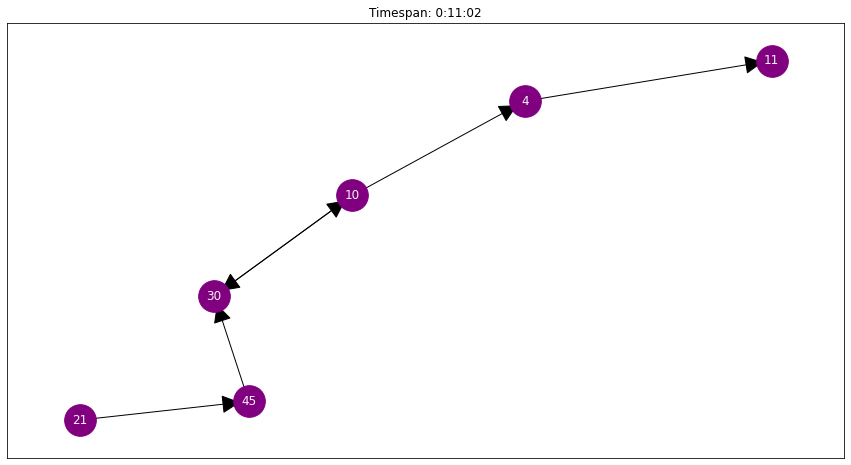

In [30]:
create_graph(create_nodes(token_2), 1)

In [31]:
token_3

,token_id,sender,receiver
13,137000934,52,30
14,137000934,30,10
15,137000934,10,30
16,137000934,30,10
17,137000934,10,4
18,137000934,4,11


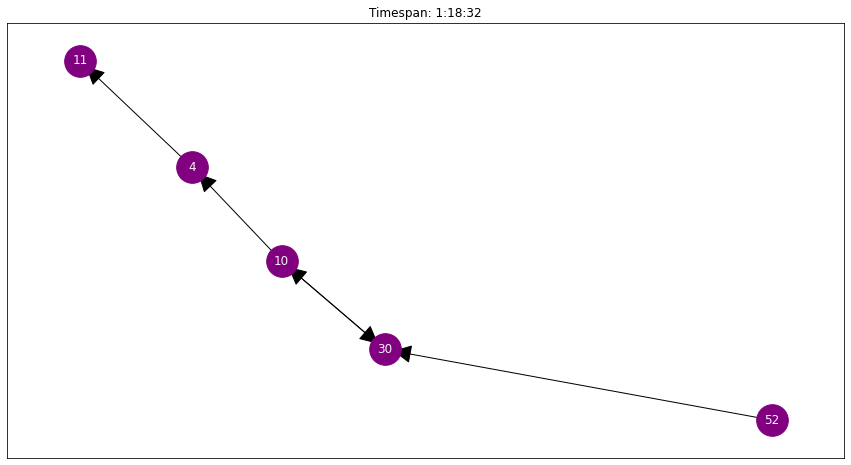

In [32]:
create_graph(create_nodes(token_3), 2)

In [33]:
token2_3 = pd.concat([token_2, token_3])
token2_3

,token_id,sender,receiver
6,137000286,21,45
7,137000286,45,30
8,137000286,30,10
9,137000286,10,30
10,137000286,30,10
11,137000286,10,4
12,137000286,4,11
13,137000934,52,30
14,137000934,30,10
15,137000934,10,30


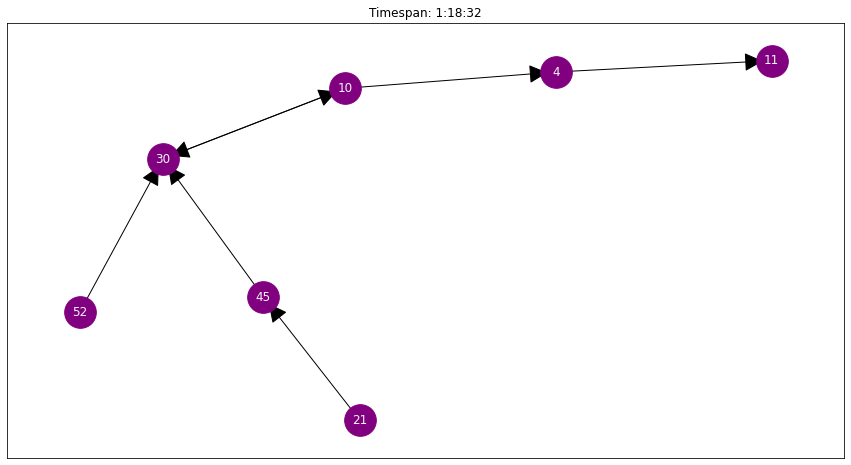

In [35]:
create_graph(create_nodes(token2_3), 2)

In [36]:
token_4

,token_id,sender,receiver
19,162000456,22,26
20,162000456,26,28
21,162000456,28,39
22,162000456,39,9


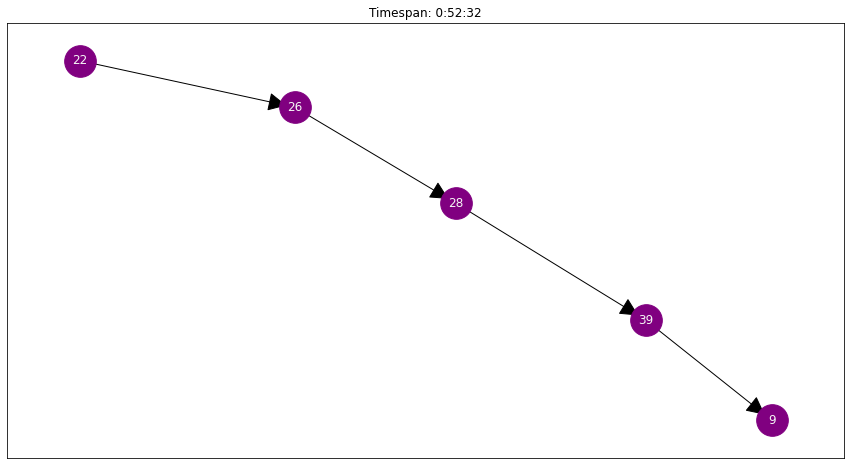

In [37]:
create_graph(create_nodes(token_4), 3)

In [38]:
token_5

,token_id,sender,receiver
23,164000949,44,3
24,164000949,3,32
25,164000949,32,14


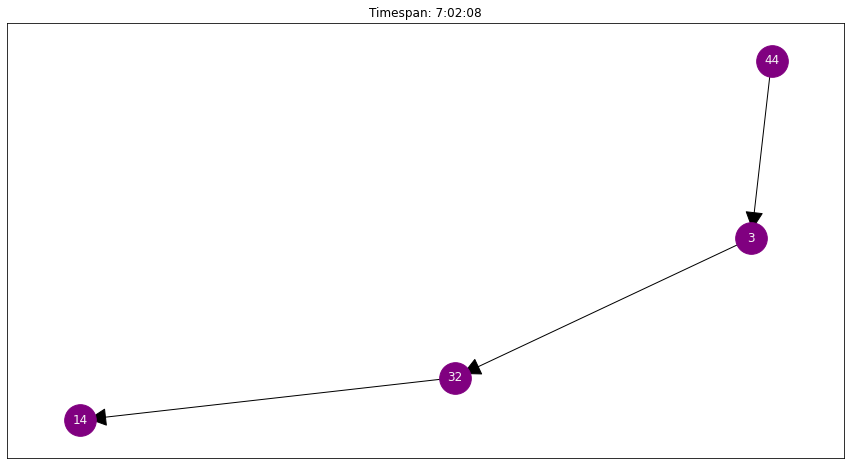

In [39]:
create_graph(create_nodes(token_5), 4)

In [40]:
token_6

,token_id,sender,receiver
26,16770,31,48
27,16770,48,23
28,16770,23,48
29,16770,37,34
30,16770,1,16
31,16770,34,37
32,16770,8,24
33,16770,50,17
34,16770,17,29
35,16770,6,42


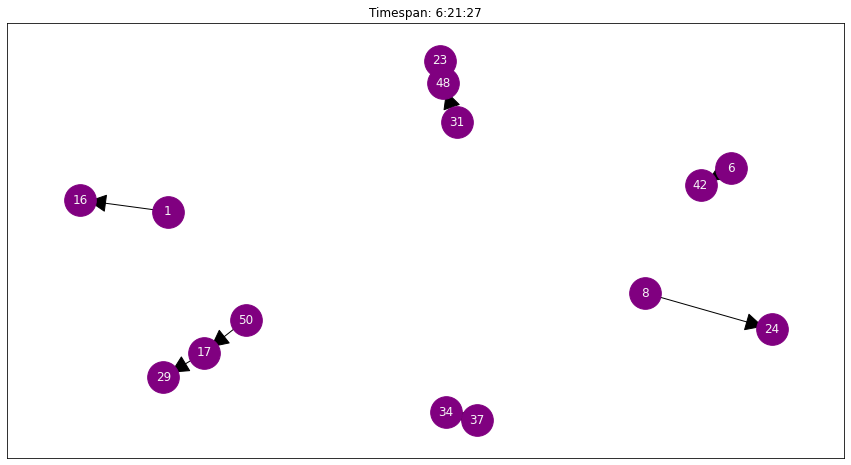

In [41]:
create_graph(create_nodes(token_6), 5)

In [42]:
token_7

,token_id,sender,receiver
36,23000433,49,18
37,23000433,18,46
38,23000433,46,18
39,23000433,18,46
40,23000433,46,47


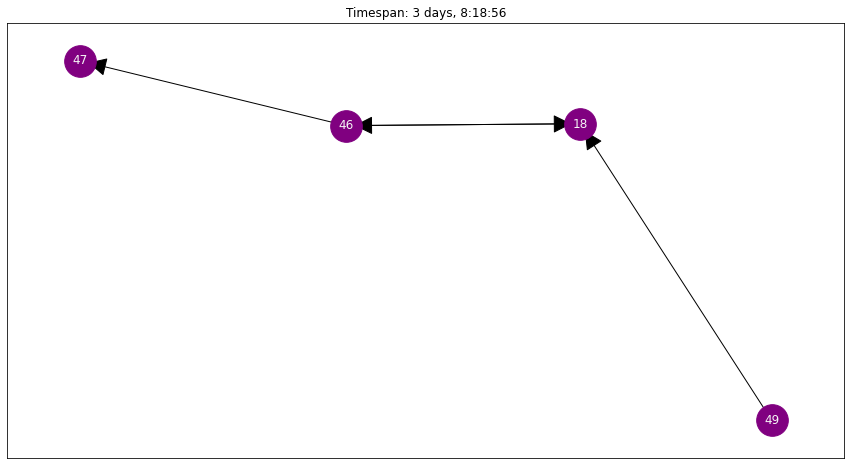

In [43]:
create_graph(create_nodes(token_7), 6)

In [44]:
token_8

,token_id,sender,receiver
41,333355,12,27
42,333355,27,25
43,333355,25,15
44,333355,15,5


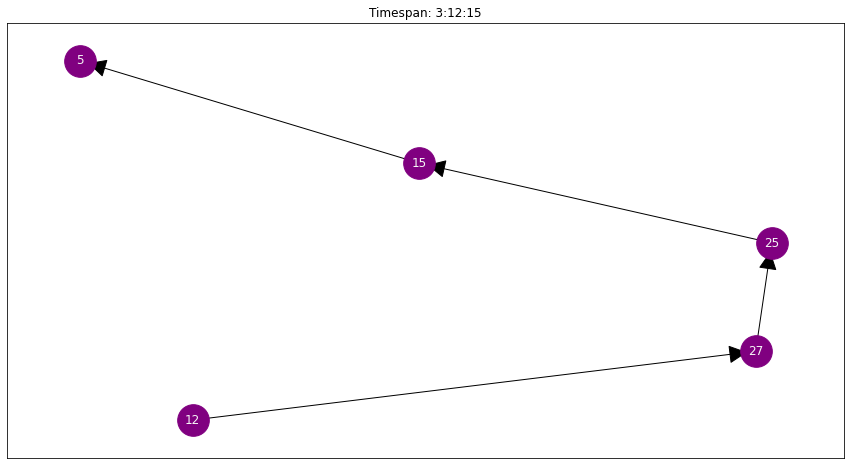

In [45]:
create_graph(create_nodes(token_8), 7)

In [46]:
token_9

,token_id,sender,receiver
45,7000100,35,2
46,7000100,2,13
47,7000100,13,33
48,7000100,33,13
49,7000100,13,33
50,7000100,33,0
51,7000100,0,43


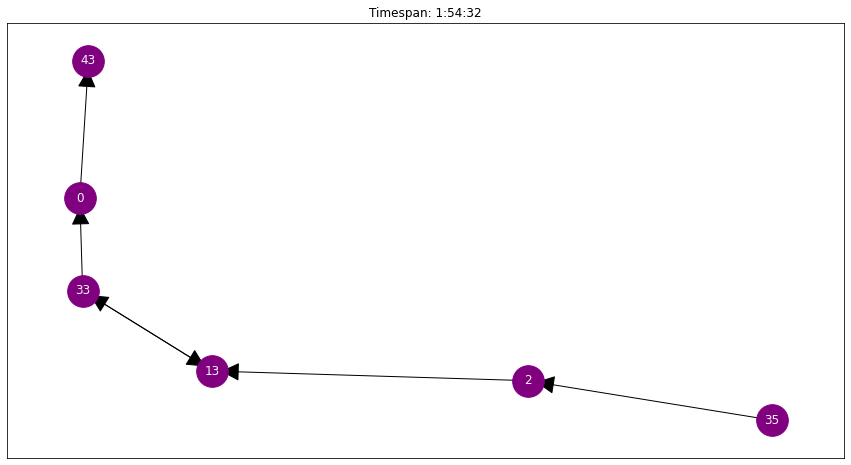

In [47]:
create_graph(create_nodes(token_9), 8)

In [48]:
token_10

,token_id,sender,receiver
52,731640,40,41
53,731640,41,40
54,731640,40,41


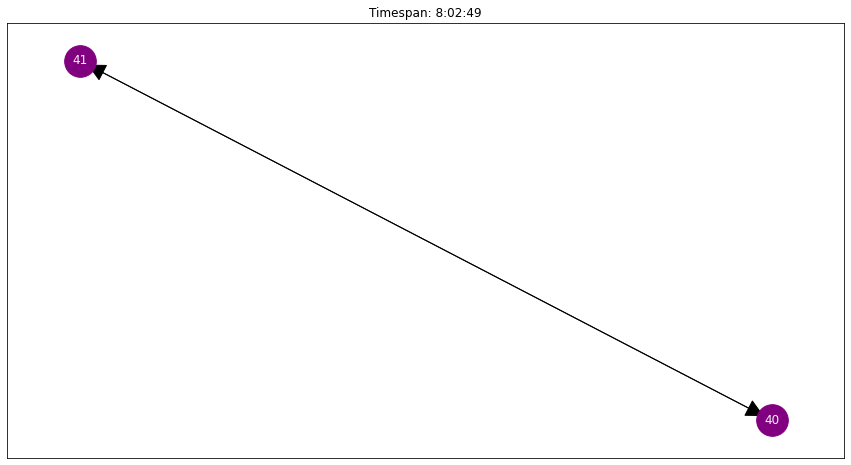

In [49]:
create_graph(create_nodes(token_10), 9)

## 1c. Focus on Token 6 and why it's Disjoint

In [50]:
sql_1d = """
select nfts.name, transfers.transaction_value, transfers.timestamp, nfts.address, transfers.token_id
from nfts
inner join transfers
on nfts.address = transfers.nft_address
where transfers.token_id = '16770';
"""

c.execute(sql_1d)
data_1d = c.fetchall()

In [52]:
df_1d = pd.DataFrame(data_1d)
df_1d.columns = ['name', 'transaction_val', 'timestamp', 'nft_address', 'token_id']
df_1d['timestamp'] = df_1d['timestamp'].apply(lambda x: dt.fromtimestamp(x))
df_1d.sort_values(by=['timestamp'])

,name,transaction_val,timestamp,nft_address,token_id
8,FND NFT,0,2021-04-01 02:52:54,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770
9,FND NFT,0,2021-05-31 04:52:23,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770
7,FND NFT,0,2021-07-21 07:07:41,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,16770
0,Ape Island - Season 1,0,2021-08-15 01:55:46,0x09B9905A472Aa1D387c9C1D8D956afF5463837E8,16770
1,Acclimated​MoonCats,0,2021-08-19 13:26:07,0xc3f733ca98E0daD0386979Eb96fb1722A1A05E69,16770
2,Ape Island - Season 1,0,2021-08-24 06:53:50,0x09B9905A472Aa1D387c9C1D8D956afF5463837E8,16770
3,POAP,2500000000000000000,2021-08-27 13:42:32,0x22C1f6050E56d2876009903609a2cC3fEf83B415,16770
4,Adam Bomb Squad,240000000000000000,2021-08-27 13:48:44,0x7AB2352b1D2e185560494D5e577F9D3c238b78C5,16770
5,Adam Bomb Squad,300000000000000000,2021-08-27 13:53:34,0x7AB2352b1D2e185560494D5e577F9D3c238b78C5,16770
6,Colonists,0,2021-09-02 22:26:43,0x9F4dF153D95A8460f6E82C21cAb92719781faB84,16770


In [ ]:
sql_1e = """
select nfts.name, transfers.transaction_value, transfers.timestamp, nfts.address, transfers.token_id
from nfts
inner join transfers
on nfts.address = transfers.nft_address
where transfers.token_id = '1208824';
"""

c.execute(sql_1e)
data_1e = c.fetchall()

In [ ]:
df_1e = pd.DataFrame(data_1e)
df_1e.columns = ['name', 'transaction_val', 'timestamp', 'nft_address', 'token_id']
df_1e['timestamp'] = df_1e['timestamp'].apply(lambda x: dt.fromtimestamp(x))
df_1e

In [ ]:
np.unique(df_1c['token_id'])

### 2. Price Forecasting for top NFT Projects

In [56]:
for_sql = """
select nft_address, avg(transaction_value)
from transfers 
group by nft_address
order by avg(transaction_value) desc
limit 10;
"""

c.execute(for_sql)
for_data = c.fetchall()

In [57]:
for_df = pd.DataFrame(for_data)
for_df.columns = ['nft_address', 'avg_transaction_val']
for_df

,nft_address,avg_transaction_val
0,0xECf7EF42B57ee37A959BF507183C5dD6bf182081,8.101797e+19
1,0x3D9b128cE781A4a9C1057f785D97131A6357ca38,6.000000e+19
2,0x371020c4a69457935584F68000E4F883e4e8Ed98,5.000023e+19
3,0xd754937672300Ae6708a51229112dE4017810934,4.921222e+19
4,0xfD1539Ee9ccAD1aB5D9b4877097CfD8221815b47,4.895548e+19
5,0x44b48a6FF0870b4c55F8Bd82a810d51ECcAC2F63,2.557500e+19
6,0x36F379400DE6c6BCDF4408B282F8b685c56adc60,2.456896e+19
7,0x80F1Ed6A1Ac694317dC5719dB099a440627D1ea7,2.237439e+19
8,0xef8D0ca2077aA54732C2b308D37bCEd393911E7E,1.633000e+19
9,0xd4e4078ca3495DE5B1d4dB434BEbc5a986197782,1.577098e+19


#### JOSIE

In [63]:
josie_sql = """
select token_id, from_address, to_address, transaction_value, timestamp 
from transfers
where nft_address = '0xECf7EF42B57ee37A959BF507183C5dD6bf182081'
order by timestamp;
"""

c.execute(josie_sql)
josie_data = c.fetchall()

In [66]:
josie_df = pd.DataFrame(josie_data)
josie_df.columns = ['token_id', 'sender', 'receiver', 'transaction_value', 'time']
josie_df['time'] = josie_df['time'].apply(lambda x: dt.fromtimestamp(x))
josie_df['transaction_value'] = josie_df['transaction_value'].apply(lambda x: x/(10**18))

In [73]:
josie_df

,token_id,sender,receiver,transaction_value,time
0,110,0xc24D112C58a87C17a0484b2a7D8fD69E1B625CCf,0x4bbb41F61fFfc1Bbe65a2aa192C65281E16eA758,5.000,2021-04-10 23:24:14
1,20,0x5E8f92C5BfAd1c18Db148e563BE7c9d02B342DB2,0xEad7DD1b34E284DE9A864BBE2f4db63BFa7a7D0E,0.000,2021-04-17 11:16:24
2,131,0x6B78BF82d240AeB1faF35808a2f702693B00D307,0xa8Cd175226EeF26E27a53fb2E3C3DC76f5D09AF1,0.000,2021-04-28 00:59:03
3,13,0x05D48eE3e815bf376fC79D283301CFDef872E280,0xd210DC1dd26751503CbF1B8c9154224707820da8,0.000,2021-05-02 11:29:34
4,124,0x57115F7D04C16f3983802b7C5a2d5089A188d76A,0x4bbb41F61fFfc1Bbe65a2aa192C65281E16eA758,2.500,2021-05-11 09:45:16
5,187,0x8FE8Cd04Ad2CfFe0D09cC45386659cCF4DCfeE48,0xd9FF1Fbd68e910392dc404F8df0FCD23a64921c3,0.000,2021-05-30 18:00:01
6,111,0x04547314AFAbD1060Fe6513518584B1cA602b51c,0x31b254A8666C7810be469295646C840dd1Bc091c,0.000,2021-06-12 12:09:06
7,7,0x68B498A5ebcd1F649A7AE3f4F42d33FE067FB483,0xd37697F3c50d7108Fef25d16CAFE229753224a05,0.000,2021-07-07 01:54:46
8,119,0xD387A6E4e84a6C86bd90C158C6028A58CC8Ac459,0xE4855Ea1e26865247d412C0891184b535e2Fb849,0.000,2021-07-28 02:23:09
9,165,0xD387A6E4e84a6C86bd90C158C6028A58CC8Ac459,0xE4855Ea1e26865247d412C0891184b535e2Fb849,0.000,2021-07-28 02:24:22


Text(0, 0.5, 'Ether')

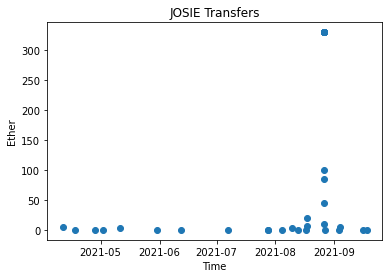

In [72]:
plt.plot_date(josie_df.time, josie_df.transaction_value)
plt.title('JOSIE Transfers')
plt.xlabel('Time')
plt.ylabel('Ether')

In [77]:
josie_mint_sql  = """
select token_id, from_address, to_address, transaction_value, timestamp
from mints
where from_address = '0x4595ff64328Faf80a8cf0D52355639984b6Af23C'
order by timestamp
"""
c.execute(josie_mint_sql)
josie_mint = c.fetchall()

In [78]:
josie_mint

[]

In [79]:
j_mint_df = pd.DataFrame(josie_mint)
j_mint_df.columns = ['token_id', 'sender', 'receiver', 'transaction_value', 'time']
j_mint_df.time = j_mint_df.time.apply(lambda x: dt.fromtimestamp(x))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements